In [2]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector

import numpy as np

We implement a Qiskit function `stateprep` that takes a vector $\psi \in \mathbb{C}^{2^n}$ such that $\|\psi\|_2 =1$, and outputs a circuit $U_\psi$ such that
$$ U_\psi |0\rangle_n = \sum_{x=0}^{2^n−1} \psi_x |x\rangle_n .$$

We will implement the amplitude and phase preparations separately. 

**Amplitude preparation** will proceed inductively on $n$, using (multi-controlled) rotation gates: given 
$$|\psi| = \sum_{x=0}^{2^n-1} |\psi|_x |x\rangle_n$$ 
with $|\psi| \in [0,1]$, we write
$$|\psi| = \cos\frac{\theta_0}2 \cdot |\psi|_a \cdot |0\rangle + \sin \frac{\theta_0}2 \cdot |\psi|_b \cdot |1\rangle$$
where $|\psi|_a = \sum_{x=0}^{2^{n-1}-1} |\psi|_x |x \rangle_n$ and $|\psi|_b = \sum_{x=0}^{2^{n-1}-1} |\psi|_{2^{n-1}+x} |x \rangle_n$, and $\theta_0 = 2 \cos^{-1} \left( \frac{\|\psi_a\|_2}{\|\psi\|_2} \right)2 =  \cos^{-1} \left( \sqrt{\frac{x_0^2 + \dots + x_{2^{n-1}-1}^2}{x_0^2 + \dots + x_{2^n-1}^2}} \right)$. 

We then recursively write $|\psi|_a$ and $|\psi|_b$ in the same form, until we obtain a expression involving products of single-qubit states. 

e.g. for $n=2$ we obtain
\begin{align*}
|\psi| & = \cos\frac{\theta_0}2 \cdot |\psi|_a \cdot |0\rangle + \sin \frac{\theta_0}2 \cdot |\psi|_b \cdot |1\rangle \\
 & = \cos\frac{\theta_0}2 \cdot  \left( \cos\frac{\theta_{10}}2 |0\rangle + \sin\frac{\theta_{10}}2 |1\rangle \right) \cdot |0\rangle + \sin \frac{\theta_0}2 \cdot \left( \cos\frac{\theta_{11}}2 |0\rangle + \sin\frac{\theta_{11}}2 |1\rangle \right) \cdot |1\rangle
\end{align*}

Amplitude preparation can then be implemented using a recursive combination of multicontrolled Y-rotations and X gates. The Y-rotations can be replaced by a combination of Z-rotations, Hadamard gates, and $S$ and $S^\dagger$ gates (using the identity $R_Y^\theta = S^\dagger H R_Z^\theta H S$). We remark that the multicontrolled Y-rotation can be expressed as a combination of (uncontrolled) Hadamard, $S$ and $S^\dagger$ gates and a multicontrolled Z-rotation: if the control qubits are all 1, then we obtain the desired rotation; if the control qubits are not all 1, the rotation does not do anything, and the surrounding (conjugating) gates cancel each other out.

**Phase preparation** proceeds similarly, using (multicontrolled) Z-rotation gates: given
$$ \psi = \sum_{x=0}^{2^n-1} e^{i\theta_x} |\psi|_x |x \rangle_n $$
with $|\psi| \in [0,1]$ and $\theta_x \in (-\pi,\pi]$, we write (with $N := 2^n$)
$$ \psi = e^{i\frac{\theta_0+\theta_{N/2}}2} ( e^{-i\frac{\theta_{N/2} - \theta_0}2}\psi_a |0 \rangle + e^{i\frac{\theta_{N/2} - \theta_0}2} \psi_b |1\rangle ) $$
where $\psi_a = \sum_{x=0}^{\frac{N}2-1} e^{i(\theta_x - \theta_0)} |\psi|_x |x\rangle_n$ and $\psi_b = \sum_{x=0}^{\frac{N}2-1} e^{i(\theta_{N/2+x} - \theta_{N/2})}  |\psi|_{\frac{N}2+x} |x\rangle_n$. 

We then recursively write $\psi_a$ and $\psi_b$ in the same form, until we obtain a expression involving products of single-qubit states.

e.g. for $n=2$, we have (neglecting a global phase factor of $e^{i\frac{\theta_0+\theta_2}2}$ going from the second to the third line)
\begin{align*}
\psi & = e^{i\frac{\theta_0+\theta_2}2} ( e^{-i\frac{\theta_2 - \theta_0}2}\psi_a |0 \rangle + e^{i\frac{\theta_2 - \theta_0}2} \psi_b |1\rangle ) \\
& = e^{i\frac{\theta_0+\theta_2}2} \left( e^{-i\frac{\theta_2 - \theta_0}2}  \left( |0\rangle + e^{i(\theta_1-\theta_0)}|1\rangle \right) |0 \rangle + e^{i\frac{\theta_2 - \theta_0}2} \left( |0\rangle + e^{i(\theta_3-\theta_2)}|1\rangle \right) |1\rangle \right) \\
&  = e^{-i\frac{\theta_2 - \theta_0}2}  e^{i\frac{\theta_1-\theta_0}2} \left( e^{-i\frac{\theta_1-\theta_0}2} |0\rangle + e^{i\frac{\theta_1-\theta_0}2}|1\rangle \right) |0 \rangle + e^{i\frac{\theta_2 - \theta_0}2} e^{i\frac{\theta_3-\theta_2}2} \left( e^{-i\frac{\theta_3-\theta_2}2} |0\rangle + e^{i\frac{\theta_3-\theta_2}2}|1\rangle \right) |1\rangle \\
& = e^{i \frac{\theta_3-\theta_2+\theta_1-\theta_0}4} \left( e^{-i\frac{\theta_2 - \theta_0}2}  e^{-i \frac{\theta_3-\theta_2-(\theta_1-\theta_0)}4} \left( e^{-i\frac{\theta_1-\theta_0}2} |0\rangle + e^{i\frac{\theta_1-\theta_0}2}|1\rangle \right) |0 \rangle + e^{i\frac{\theta_2 - \theta_0}2} e^{i \frac{\theta_3-\theta_2-(\theta_1-\theta_0)}4} \left( e^{-i\frac{\theta_3-\theta_2}2} |0\rangle + e^{i\frac{\theta_3-\theta_2}2}|1\rangle \right) |1\rangle \right) \\
& = e^{i \frac{\theta_3-\theta_2+\theta_1-\theta_0}4} \left( e^{-i \frac{\theta_3+\theta_2-\theta_1-\theta_0}4} \left( e^{-i\frac{\theta_1-\theta_0}2} |0\rangle + e^{i\frac{\theta_1-\theta_0}2}|1\rangle \right) |0 \rangle + e^{i \frac{\theta_3+\theta_2-\theta_1-\theta_0}4} \left( e^{-i\frac{\theta_3-\theta_2}2} |0\rangle + e^{i\frac{\theta_3-\theta_2}2}|1\rangle \right) |1\rangle \right)
\end{align*}

Phase preparation can then be done by placing multicontrolled Z-rotations right after the multicontrolled Y-rotations that were used for amplitude preparation.

In [4]:
def stateprep_r(amp, phase, reg):
    # helper function that is called recursively
    n = reg.size
    K = amp.size
    k = int(np.log2(K))
    stateprep_circ = QuantumCircuit(reg, name="U_psi")
    
    # amplitude preparation
    if sum(amp**2) > 0: 
        ampang = 2*np.arccos(np.sqrt(sum(amp[:(K>>1)]**2) / sum(amp**2)))
        stateprep_circ.sdg(reg[k-1])
        stateprep_circ.h(reg[k-1])
        if k < n: 
            stateprep_circ.mcrz(ampang,reg[k:],reg[k-1])
        else: 
            stateprep_circ.rz(ampang,reg[k-1])
        stateprep_circ.h(reg[k-1])
        stateprep_circ.s(reg[k-1])

    # phase preparation
    theta = (sum(phase[K>>1:])-sum(phase[:K>>1]))/(1<<(k-1))
    if k < n: 
        stateprep_circ.mcrz(theta,reg[k:],reg[k-1])
    else: 
        stateprep_circ.rz(theta,reg[k-1])

    # recursively prepare less significant qubits
    if k > 1:
        stateprep_circ.x(reg[k-1])
        stateprep_circ.compose(stateprep_r(amp[:K>>1],phase[:K>>1],reg),inplace=True) 
        stateprep_circ.x(reg[k-1])
        stateprep_circ.compose(stateprep_r(amp[K>>1:],phase[K>>1:],reg),inplace=True) 

    return stateprep_circ

def stateprep(psi):
    # main function
    n = int(np.log2(psi.size))
    if n < np.log2(psi.size): raise Exception("Input vector of wrong size!")

    reg = QuantumRegister(size = n, name="x")
    return stateprep_r(np.abs(psi), np.angle(psi), reg)


**Asymptotic complexity analysis**

This circuit uses $n$ qubits (no ancillas), and requires $O(2^n)$ (multicontrolled) gates and $O(2^n)$ depth. It seems hard to do better in general, although we might expect to do better e.g. for sparse states, or states with additional structure.

**Testing for $n=1$**

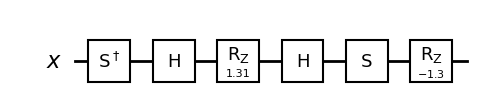

In [5]:
# Generate random state vector for input
relphase = np.random.random()*2*np.pi
amp1 = np.random.random()
amp2 = np.sqrt(1-amp1**2)
psi = np.array([amp1,amp2*np.exp(relphase*(1.j))])

# Create circuit
circ = stateprep(psi)
circ.draw(output="mpl", style="bw")

In [6]:
# Compare prepared state with input vector
prepared = Statevector(circ)

# note the prepared state may differ from the input vector by a global phase
# since our test vectors are normalized so that the first component has no phase, the following line corrects for this, for comparison purposes.
prepared /= (prepared[0]/np.abs(prepared[0]))

np.round(psi,3), np.round(prepared,3)

(array([0.794+0.j   , 0.161-0.587j]), array([0.794-0.j   , 0.161-0.587j]))

**Testing for $n=2$**

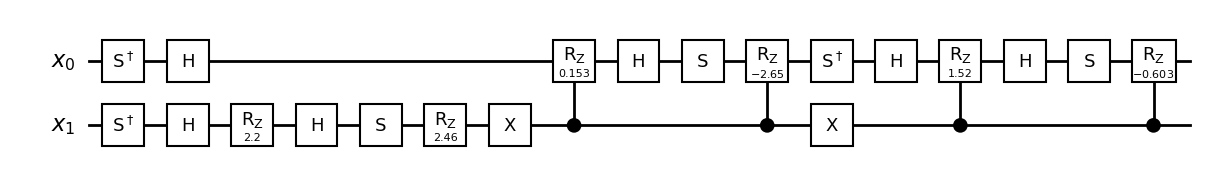

In [7]:
# Generate random state vector for input
N=1<<2
amps = np.random.random(N)
amps /= np.sqrt(sum(amps**2))
phases = np.random.random(N)*2*np.pi
phases -= phases[0]

psi = np.array([amps[i]*np.exp(phases[i]*(1.j)) for i in range(N)])

# Create circuit
circ = stateprep(psi)
circ.draw(output="mpl", style="bw")

In [8]:
# Compare prepared state with input vector
prepared = Statevector(circ)

# note the prepared state may differ from the input vector by a global phase
# since our test vectors are normalized so that the first component has no phase, the following line corrects for this, for comparison purposes.
prepared /= (prepared[0]/np.abs(prepared[0]))

np.round(psi,3), np.round(prepared,3)

(array([ 0.451+0.j   , -0.031-0.016j,  0.088+0.639j,  0.415+0.455j]),
 array([ 0.451+0.j   , -0.031-0.016j,  0.088+0.639j,  0.415+0.455j]))

**Demonstration for $n=3$**

In [9]:
# Generate random state vector for input
N=1<<3
amps = np.random.random(N)
amps /= np.sqrt(sum(amps**2))
phases = np.random.random(N)
phases -= phases[0]

psi = np.array([amps[i]*np.exp(phases[i]*np.pi*(1.j)) for i in range(N)])

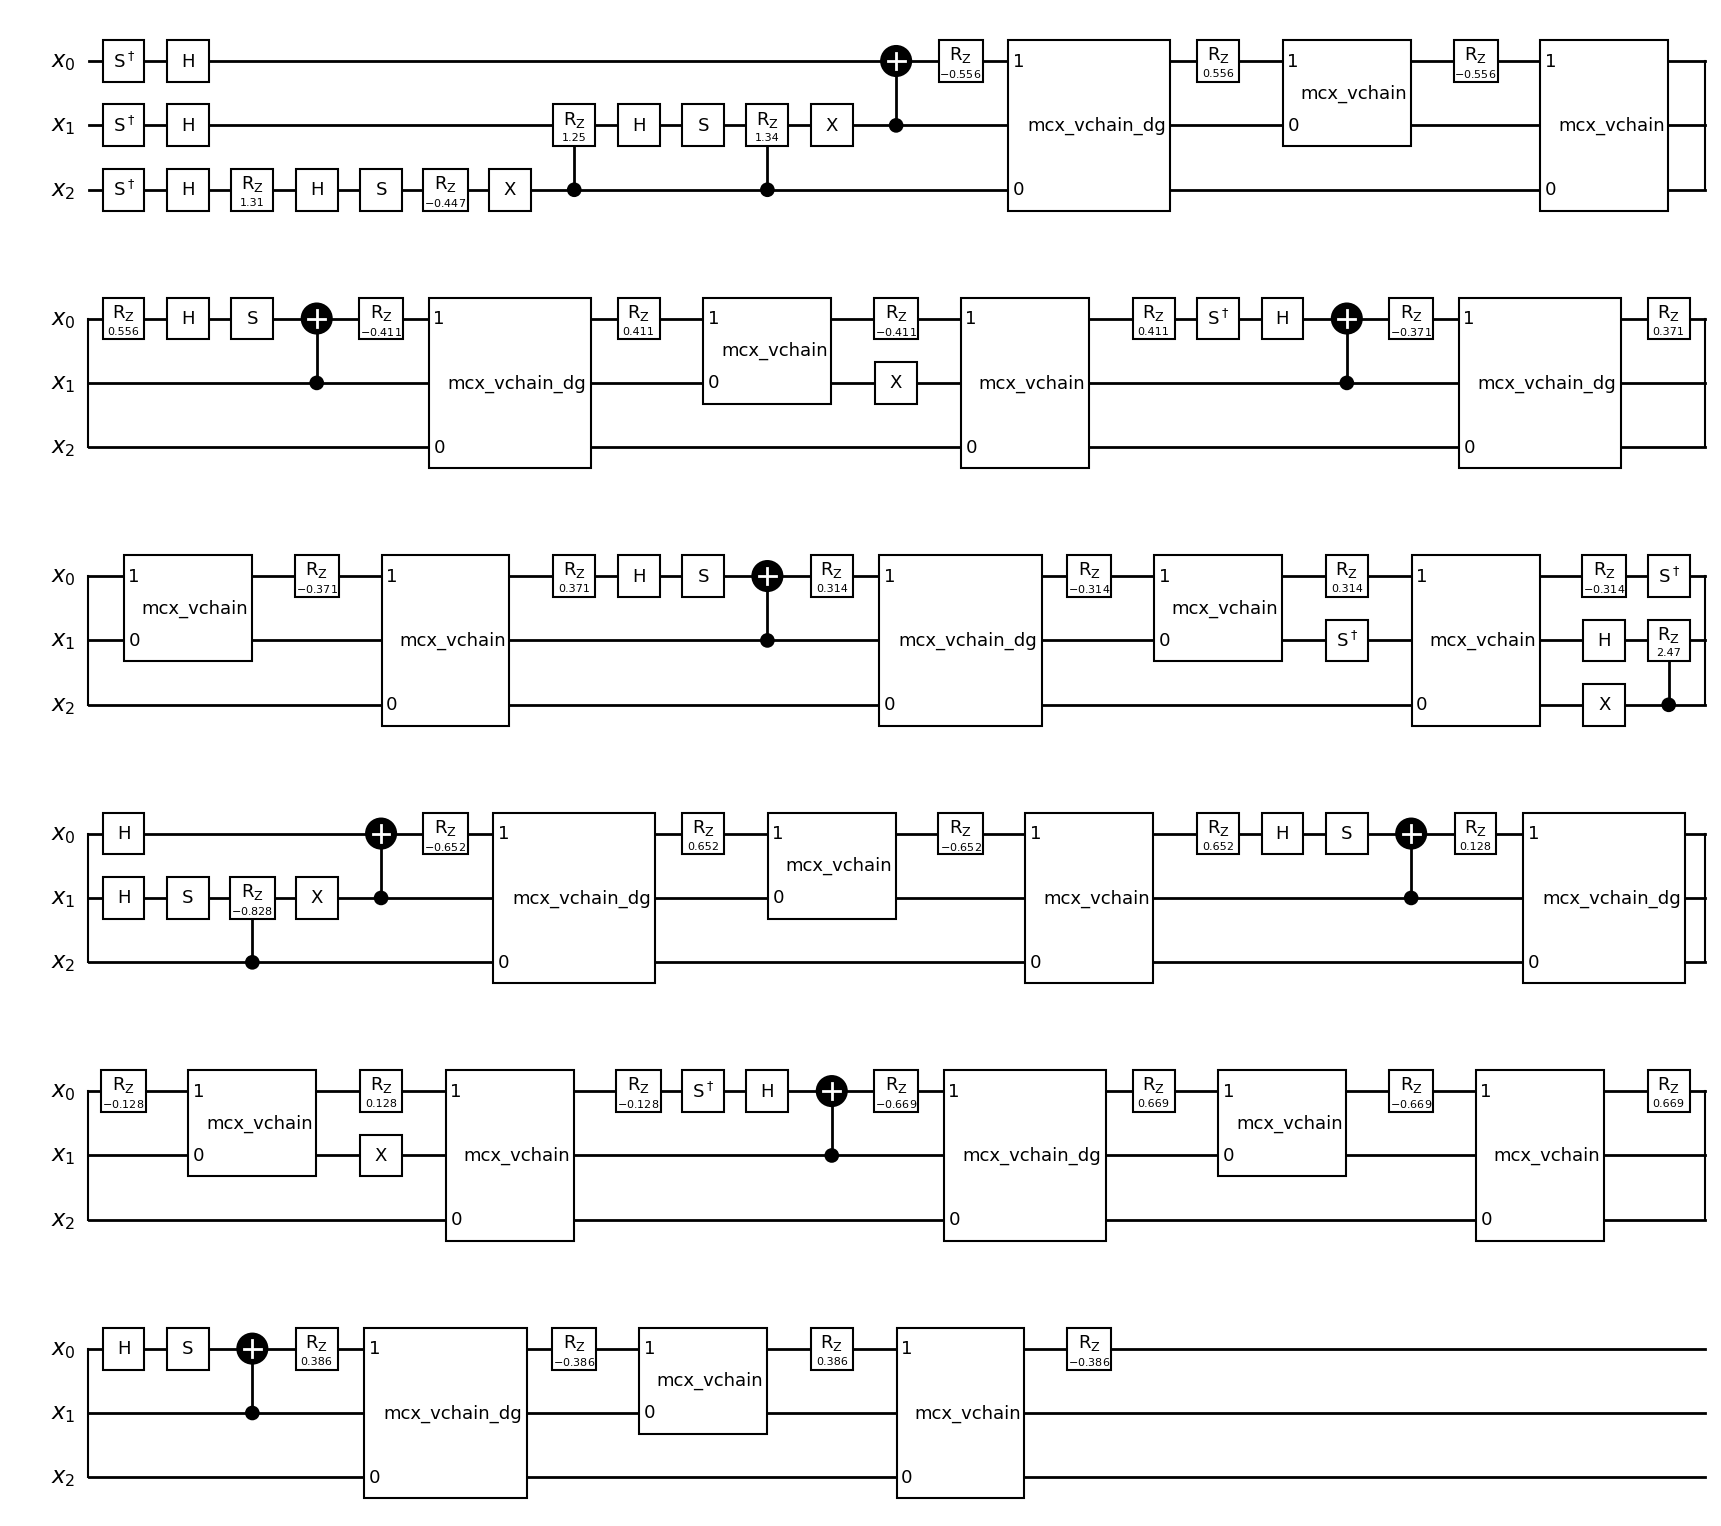

In [10]:
# Create circuit
circ = stateprep(psi)
circ.draw(output="mpl", style="bw")

In [11]:
# Compare prepared state with input vector
prepared = Statevector(circ)

# note the prepared state may differ from the input vector by a global phase
# since our test vectors are normalized so that the first component has no phase, the following line corrects for this, for comparison purposes.
prepared /= (prepared[0]/np.abs(prepared[0]))

np.round(psi,4), np.round(prepared,4)

(array([ 0.2847+0.j    , -0.0415+0.5734j, -0.3213+0.1197j,  0.0129+0.3141j,
        -0.0076+0.0529j,  0.0709+0.1819j,  0.0225+0.1305j,  0.5543-0.08j  ]),
 array([ 0.2847-0.j    , -0.0415+0.5734j, -0.3213+0.1197j,  0.0129+0.3141j,
        -0.0076+0.0529j,  0.0709+0.1819j,  0.0225+0.1305j,  0.5543-0.08j  ]))

**Demonstration for $n=4$**

In [12]:
# Generate random state vector for input
N=1<<4
amps = np.random.random(N)
amps /= np.sqrt(sum(amps**2))
phases = np.random.random(N)
phases -= phases[0]

psi = np.array([amps[i]*np.exp(phases[i]*np.pi*(1.j)) for i in range(N)])

In [13]:
# Create circuit
circ = stateprep(psi)

In [14]:
# Compare prepared state with input vector
prepared = Statevector(circ)

# note the prepared state may differ from the input vector by a global phase
# since our test vectors are normalized so that the first component has no phase, the following line corrects for this, for comparison purposes.
prepared /= (prepared[0]/np.abs(prepared[0]))

np.round(psi,4), np.round(prepared,4)

(array([0.3005+0.j    , 0.0076-0.0246j, 0.1473+0.1565j, 0.3909-0.0326j,
        0.1197-0.3553j, 0.2799+0.2044j, 0.0059-0.1124j, 0.0167-0.0807j,
        0.0093+0.021j , 0.1326+0.1957j, 0.0761-0.1307j, 0.2491-0.1144j,
        0.2441+0.0577j, 0.0197+0.0032j, 0.3183+0.1008j, 0.2763+0.1526j]),
 array([0.3005+0.j    , 0.0076-0.0246j, 0.1473+0.1565j, 0.3909-0.0326j,
        0.1197-0.3553j, 0.2799+0.2044j, 0.0059-0.1124j, 0.0167-0.0807j,
        0.0093+0.021j , 0.1326+0.1957j, 0.0761-0.1307j, 0.2491-0.1144j,
        0.2441+0.0577j, 0.0197+0.0032j, 0.3183+0.1008j, 0.2763+0.1526j]))